# Batch Active Learning

While it is possible to perform rudimentary data selection simply by randomly choosing samples, the batch of data thus drawn might not be the most informative one.
Choosing those samples with the largest prediction uncertainties from trajectories often results in the selection of configurations from subsequent time steps.

Batch selection methods can be constructed to select informative and diverse data, with or without following the underlying distribution.

We will illustrate this in a mock learning on the fly setup.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import yaml
from ase import units
from ase.io import read
from ase.io.trajectory import TrajectoryWriter
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.optimize.fire import FIRE

from apax.bal import api
from apax.md import ASECalculator
from apax.utils.datasets import download_md22_benzene_CCSDT, mod_md_datasets
from apax.utils.helpers import mod_config

## Dataset Acquisition

In [3]:
# Download CCSD(T) Data
data_path = Path("project")
cc_train_file_path, cc_val_file_path = download_md22_benzene_CCSDT(data_path)
cc_train_file_path = mod_md_datasets(cc_train_file_path)
cc_val_file_path = mod_md_datasets(cc_val_file_path)

## Model Training

Unlike simpler data selection methods, such as random selection, we first need to train a model.
It is the representation learned by the model which will serve as the basis for our similarity metric.

In [7]:
!apax template train

/home/ms/miniconda3/envs/apax311/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [10]:
config_path = Path("config.yaml")

config_updates = {
    "n_epochs": 200,
    "data": {
        "batch_size": 4,
        "valid_batch_size": 100,
        "experiment": "benzene",
        "directory": "project/models",
        "train_data_path": str(cc_train_file_path),
        "val_data_path": str(cc_val_file_path),
        "data_path": None,
        "energy_unit": "kcal/mol",
        "pos_unit": "Ang",
    },
}
config_dict = mod_config(config_path, config_updates)

with open("config.yaml", "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)

In [11]:
!apax train config.yaml

/home/ms/miniconda3/envs/apax311/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


INFO | 18:13:29 | Running on [cuda(id=0)]
INFO | 18:13:29 | Initializing Callbacks
INFO | 18:13:29 | Initializing Loss Function
INFO | 18:13:29 | Initializing Metrics
INFO | 18:13:29 | Running Input Pipeline
INFO | 18:13:29 | Read training data file project/benzene_ccsd_t-train_mod.xyz
INFO | 18:13:29 | Read validation data file project/benzene_ccsd_t-test_mod.xyz
INFO | 18:13:29 | Loading data from project/benzene_ccsd_t-train_mod.xyz
INFO | 18:13:29 | Loading data from project/benzene_ccsd_t-test_mod.xyz
INFO | 18:13:30 | Computing per element energy regression.
INFO | 18:13:30 | Initializing Model
INFO | 18:13:30 | initializing 1 models
INFO | 18:13:34 | Initializing Optimizer
INFO | 18:13:34 | Beginning Training
Epochs: 100%|██████████████████████████████████| 200/200 [01:31<00:00,  2.18it/s, val_loss=0.000692]
INFO | 18:15:06 | Finished training


## Molecular Dynamics / Data Generation

Now we will create a pool of data to select new samples from.
In order to emphasize the selection method used in the next section, we will combine MD and geometry optimization, a common occurrence in learning on the fly.

In [40]:
atoms = read(str(cc_train_file_path), "0")
calc = ASECalculator("project/models/benzene")
atoms.calc = calc

In [42]:
def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(
        "Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  "
        "Etot = %.3feV" % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin)
    )


writer = TrajectoryWriter("project/benzene.traj", "w", atoms)

MaxwellBoltzmannDistribution(atoms, temperature_K=298)
dyn = Langevin(atoms, 0.5 * units.fs, temperature_K=298, friction=0.002)
dyn.attach(writer, interval=100)
dyn.attach(printenergy, interval=1000)
dyn.run(10000)

opt = FIRE(atoms)
opt.attach(writer)
opt.run()

Energy per atom: Epot = -524.783eV  Ekin = 0.042eV (T=322K)  Etot = -524.741eV
Energy per atom: Epot = -524.784eV  Ekin = 0.032eV (T=246K)  Etot = -524.752eV
Energy per atom: Epot = -524.786eV  Ekin = 0.037eV (T=287K)  Etot = -524.749eV
Energy per atom: Epot = -524.784eV  Ekin = 0.033eV (T=252K)  Etot = -524.752eV
Energy per atom: Epot = -524.786eV  Ekin = 0.040eV (T=307K)  Etot = -524.746eV
Energy per atom: Epot = -524.781eV  Ekin = 0.036eV (T=275K)  Etot = -524.746eV
Energy per atom: Epot = -524.783eV  Ekin = 0.038eV (T=295K)  Etot = -524.745eV
Energy per atom: Epot = -524.777eV  Ekin = 0.031eV (T=242K)  Etot = -524.745eV
Energy per atom: Epot = -524.772eV  Ekin = 0.038eV (T=292K)  Etot = -524.735eV
Energy per atom: Epot = -524.776eV  Ekin = 0.039eV (T=305K)  Etot = -524.736eV
Energy per atom: Epot = -524.788eV  Ekin = 0.055eV (T=427K)  Etot = -524.733eV
      Step     Time          Energy         fmax
FIRE:    0 18:31:17    -6297.460205        2.9797
FIRE:    1 18:31:17    -6297.640

True

## Selecting New Datapoints

Now it is time to select new data points from our pool.
In the following we choose the last-layer gradient kernel as the similarity metric and the max dist selection method (farthest point sampling) to select 10 datapoints from out pool.

In [4]:
train_atoms = read(str(cc_train_file_path), ":")
pool_atoms = read("project/benzene.traj", ":")

In [5]:
len(pool_atoms)

142

In [6]:
base_fm_options = {"name": "ll_grad", "layer_name": "dense_2"}
selection_method = "max_dist"

bs = 10

selected_indices = api.kernel_selection(
    "project/models/benzene",
    train_atoms,
    pool_atoms,
    base_fm_options,
    selection_method,
    selection_batch_size=bs,
    processing_batch_size=bs,
)

Computing features: 100%|██████████████████████████████████████| 1142/1142 [00:04<00:00, 273.60it/s]

(1142, 513)


In [7]:
selected_indices

array([139,  99,   1,  34, 102,  78,   4,  17,  97,  72])

In [8]:
energies = np.array([a.get_potential_energy() for a in pool_atoms])
# selected_indices = np.random.randint(0, len(energies), 10)
selection_energies = energies[selected_indices]

As we can see below, the batch selection method only picks a few data points from the optimization part of the pool, indicating that during an optimization the structure of the molecule does not change very much.
Hence, there are not many informative samples to be found in it.

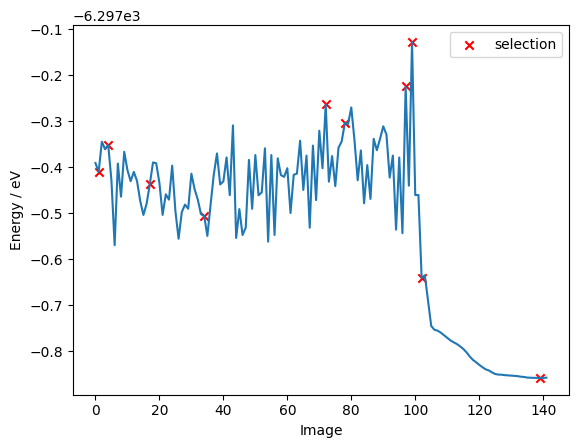

In [9]:
fig, ax = plt.subplots()

ax.plot(energies)
ax.scatter(
    selected_indices, selection_energies, marker="x", color="red", label="selection"
)
ax.set_ylabel("Energy / eV")
ax.set_xlabel("Image")
ax.legend()